In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import GRU
from keras import regularizers
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sn
import itertools  
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import random
from sklearn.utils import resample
import matplotlib.pyplot as plt
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK

Using TensorFlow backend.


In [3]:
#Function to print confusion matrix in a nice format.
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [4]:
##Specifying training data parameters.
years=range(2000,2019)
num_years=5
#Features/columns that will be used for prediction.
features=["count", "County_type","Incident_nominal"]

In [5]:
#Importing training and testing data
train_path="C:/Users/andre/NCSA_Python/SPIN_CDC/Temporal_df.csv"
temporal_df=pd.read_csv(train_path)
test_path="C:/Users/andre/NCSA_Python/SPIN_CDC/Temporal_df_test.csv"
temporal_df_test=pd.read_csv(test_path)

In [6]:
#Importing county names
county_path="C:/Users/andre/NCSA_Python/SPIN_CDC/County_name.csv"
df_county=pd.read_csv(county_path)

In [7]:
temporal_df.head()

,A,B,C,D,E,F,G,H,I,J,...,6,7,8,9,10,11,12,13,14,15
0,1,1,1,0,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#Checking frequency of instances for each class
dict_freq={}
for i in range(1,16):
    dict_freq[i]=len(temporal_df[temporal_df[str(i)]==1])
dict_freq

{1: 35213,
 2: 4648,
 3: 312,
 4: 88,
 5: 39,
 6: 28,
 7: 13,
 8: 8,
 9: 5,
 10: 5,
 11: 5,
 12: 15,
 13: 7,
 14: 3,
 15: 2}

In [9]:
#Using unbalanced data
temporal_df = temporal_df.sample(frac = 1,random_state=5) #Shuffling the data
X_pre = temporal_df.iloc[:, 0:(num_years*len(features))]
Y_pre = temporal_df.iloc[:, (num_years*len(features)):]
X=X_pre.values
Y=Y_pre.values

In [10]:
#Successful oversampling of data? code runs but might not actually oversample?
#Will be updated, eventually.  For this version, it is unnecessary
#ros=RandomOverSampler(sampling_strategy="auto")
#y_name=np.array(temporal_df.index)
#test_temporal_df,y_test_temporal=ros.fit_sample(temporal_df,y_name)
#test_pre = test_temporal_df.iloc[:, (num_years*len(features)):]
#testY = test_pre.values
#test_temporal_df

In [11]:
#Shows all the class labels are now equally represented
y=np.argmax(Y, axis=1)
np.bincount(y)

array([35213,  4648,   312,    88,    39,    28,    13,     8,     5,
           5,     5,    15,     7,     3,     2], dtype=int64)

## LSTM Implementation for classification

Hyperparameter Tuning

In [12]:
def create_network_hyp(nodes_1,lstm_node,dropout,recurrent_dropout):
    network = Sequential()
    network.add(BatchNormalization(input_shape=(num_years, len(features))))
    network.add(Dense(nodes_1, activation="tanh"))
    network.add(LSTM(lstm_node, dropout = dropout, recurrent_dropout = recurrent_dropout, activation="tanh"))
    network.add(Dense(15, activation="softmax"))
    network.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
    return network

In [13]:
#Objective function to be minimized
def objective(params):
    nodes_1=params["nodes_1"]
    dropout=params["dropout"]
    recurrent_dropout=params["recurrent_dropout"]
    lstm_node=params["lstm_node"]
    
    indices=[i for i in range(len(X))]
    indices=shuffle(indices, random_state=4)
    split_ratio=0.8    #80-20 split ratio for train-val set
    train_index=indices[0:int(split_ratio*len(X))]
    val_index=indices[int(split_ratio*len(X)):]

    
    X_pre_train = temporal_df.iloc[train_index, 0:(num_years*len(features))]
    Y_pre_train = temporal_df.iloc[train_index, (num_years*len(features)):]
    X_pre_val = temporal_df.iloc[val_index, 0:(num_years*len(features))]
    Y_pre_val = temporal_df.iloc[val_index, (num_years*len(features)):]
    X_pre_train_combine=pd.concat([X_pre_train, Y_pre_train], axis=1)
    
    #Oversampling the training data to balance the classes
    num_cl=len(X_pre_train_combine[X_pre_train_combine["1"]==1])
    df_balanced=X_pre_train_combine[X_pre_train_combine["1"]==1]
    df_balanced_train = df_balanced.sample(frac = 1, random_state=4)   #Shuffling the data
    X_pre_train = df_balanced_train.iloc[:, 0:(num_years*len(features))]
    Y_pre_train = df_balanced_train.iloc[:, (num_years*len(features)):]
    #ros=RandomOverSampler(sampling_strategy="auto")
    #y=np.array(temporal_df.columns)
    #test_temporal_df=ros.fit_resample(temporal_df,y)
    
    
    X_train=X_pre_train.values
    Y_train=Y_pre_train.values
    X_val=X_pre_val.values
    Y_val=Y_pre_val.values
    
    #Transforming input variables into LSTM input format
    X_train = X_train.reshape(X_train.shape[0], num_years, len(features))
    X_val = X_val.reshape(X_val.shape[0], num_years, len(features))
    Y_train=Y_train
    Y_val=Y_val
    
    #Creating model
    model=create_network_hyp(nodes_1,lstm_node,dropout,recurrent_dropout)
    Hist=model.fit(X_train, Y_train, epochs=1, validation_data=(X_val, Y_val), verbose=2, class_weight=None)
    
    #Final epoch accuracies for validation dataset
    acc_val=Hist.history["val_accuracy"][-1]

    return -acc_val   #Minimizing the objective function

In [14]:
#Declaring hyperparameter search space
space={"nodes_1": hp.choice("nodes_1", range(4,20)), "dropout": hp.uniform("dropout", 0.1, 0.4),"lstm_node":hp.choice("lstm_node", range(15,20)), "recurrent_dropout": hp.uniform("recurrent_dropout", 0.1, 0.4)}

In [15]:
# Create a trials object
tpe_trials = Trials()
# Create the algorithm
tpe_algo = tpe.suggest

In [16]:
# Run bayesian optimization for hyperparameter tuning
tpe_best = fmin(fn=objective, space=space, algo=tpe_algo, trials=tpe_trials, max_evals=5)

Train on 28125 samples, validate on 8079 samples     
Epoch 1/1                                            
 - 3s - loss: 0.2088 - accuracy: 0.9673 - val_loss: 1.1858 - val_accuracy: 0.8773

Train on 28125 samples, validate on 8079 samples                               
Epoch 1/1                                                                      
 - 3s - loss: 0.2266 - accuracy: 0.9693 - val_loss: 1.2235 - val_accuracy: 0.8773

Train on 28125 samples, validate on 8079 samples                               
Epoch 1/1                                                                      
 - 3s - loss: 0.2265 - accuracy: 0.9746 - val_loss: 1.2447 - val_accuracy: 0.8773

Train on 28125 samples, validate on 8079 samples                               
Epoch 1/1                                                                      
 - 3s - loss: 0.2462 - accuracy: 0.9705 - val_loss: 1.0538 - val_accuracy: 0.8773

Train on 28125 samples, validate on 8079 samples                               


In [17]:
tpe_results = pd.DataFrame({'Accuracy': [-x['loss'] for x in tpe_trials.results], 
                            'iteration': tpe_trials.idxs_vals[0]['nodes_1'],
                            'nodes_1': tpe_trials.idxs_vals[1]['nodes_1'],
                            'dropout': tpe_trials.idxs_vals[1]['dropout'],
                            'recurrent_dropout': tpe_trials.idxs_vals[1]['recurrent_dropout']})
                            
tpe_results.head()

,Accuracy,iteration,nodes_1,dropout,recurrent_dropout
0,0.877336,0,9,0.279128,0.260853
1,0.877336,1,9,0.194803,0.327353
2,0.877336,2,7,0.190494,0.204454
3,0.877336,3,9,0.297436,0.126734
4,0.877336,4,15,0.100162,0.171521


In [18]:
#Best parameters
print(tpe_best)

{'dropout': 0.27912836935043517, 'lstm_node': 4, 'nodes_1': 9, 'recurrent_dropout': 0.26085314270410476}


Training of model after hyperparameter tuning

In [19]:
def create_network():
    network = Sequential()
    network.add(BatchNormalization(input_shape=(num_years, len(features))))
    network.add(Dense(4, activation="tanh"))
    network.add(LSTM(14, dropout = 0.2, recurrent_dropout = 0.2, activation="tanh"))
    network.add(Dense(15, activation="softmax"))
    network.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
    return network

In [33]:
#Cross-validation setup
acc_train=[]
acc_val=[]
kf = KFold(n_splits=3, shuffle=True)
for train_index, val_index in kf.split(X):   
    X_pre_train = temporal_df.iloc[train_index, 0:(num_years*len(features))]
    Y_pre_train = temporal_df.iloc[train_index, (num_years*len(features)):]
    X_pre_val = temporal_df.iloc[val_index, 0:(num_years*len(features))]
    Y_pre_val = temporal_df.iloc[val_index, (num_years*len(features)):]
    X_pre_train_combine=pd.concat([X_pre_train, Y_pre_train], axis=1)
    
    #Oversampling the training data to balance the classes
    num_cl=len(X_pre_train_combine[X_pre_train_combine["1"]==1])
    df_balanced=X_pre_train_combine[X_pre_train_combine["1"]==1]
    df_balanced_train = df_balanced.sample(frac = 1, random_state=4)   #Shuffling the data
    X_pre_train = df_balanced_train.iloc[:, 0:(num_years*len(features))]
    Y_pre_train = df_balanced_train.iloc[:, (num_years*len(features)):]
    #ros=RandomOverSampler(sampling_strategy="auto")
    #y=np.array(temporal_df.columns)
    #test_temporal_df=ros.fit_resample(temporal_df,y)
    
    
    X_train=X_pre_train.values
    Y_train=Y_pre_train.values
    X_val=X_pre_val.values
    Y_val=Y_pre_val.values
    
    #Transforming input variables into LSTM input format
    X_train = X_train.reshape(X_train.shape[0], num_years, len(features))
    X_val = X_val.reshape(X_val.shape[0], num_years, len(features))
    Y_train=Y_train
    Y_val=Y_val
    
    #Creating model
    model=create_network()
    Hist=model.fit(X_train, Y_train, epochs=2, validation_data=(X_val, Y_val), verbose=2, class_weight=None)
    
    #Final epoch accuracies for training and validation dataset
    acc_train.append(Hist.history["accuracy"][-1])
    acc_val.append(Hist.history["val_accuracy"][-1])
    
print("Training accuracy:" + str(np.mean(acc_train)))
print("Validation accuracy:" + str(np.mean(acc_val)))
    

Train on 23504 samples, validate on 13464 samples
Epoch 1/2
 - 2s - loss: 0.3349 - accuracy: 0.9489 - val_loss: 1.2542 - val_accuracy: 0.8697
Epoch 2/2
 - 2s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.3901 - val_accuracy: 0.8697
Train on 23442 samples, validate on 13464 samples
Epoch 1/2
 - 2s - loss: 0.3505 - accuracy: 0.9460 - val_loss: 1.1583 - val_accuracy: 0.8743
Epoch 2/2
 - 2s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.3079 - val_accuracy: 0.8743
Train on 23480 samples, validate on 13463 samples
Epoch 1/2
 - 2s - loss: 0.3085 - accuracy: 0.9676 - val_loss: 1.0240 - val_accuracy: 0.8715
Epoch 2/2
 - 2s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.1932 - val_accuracy: 0.8715
Training accuracy:1.0
Validation accuracy:0.8718031048774719


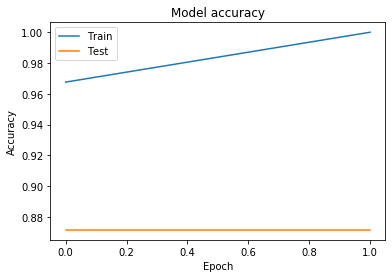

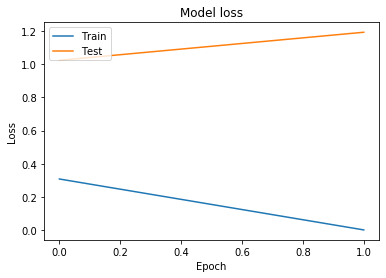

In [34]:
# Plot training & validation accuracy values
plt.plot(Hist.history['accuracy'])
plt.plot(Hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(Hist.history['loss'])
plt.plot(Hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
X_test=temporal_df_test.values
X_test = X_test.reshape(X_test.shape[0], num_years, len(features))

In [35]:
#Predicting value for train, val, and test datasets
pred_train=model.predict(X_train)
pred_val=model.predict(X_val)
pred_test=model.predict(X_test)

In [36]:
#Converting probabilities to class labels
pred_train_class=np.argmax(pred_train, axis=1)+1
pred_train_class=list(map(lambda x: str(x), pred_train_class))
pred_val_class=np.argmax(pred_val, axis=1)+1
pred_val_class=list(map(lambda x: str(x), pred_val_class))
pred_test_class=np.argmax(pred_test, axis=1)+1

In [37]:
true_train_class=np.argmax(Y_train, axis=1)+1
true_train_class=list(map(lambda x: str(x), true_train_class))
true_val_class=np.argmax(Y_val, axis=1)+1
true_val_class=list(map(lambda x: str(x), true_val_class))

In [38]:
labels = [str(i) for i in range(1,16)]
cm_train = confusion_matrix(true_train_class, pred_train_class , labels)
cm_val = confusion_matrix(true_val_class, pred_val_class , labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [39]:
print_cm(cm_train, labels)

              1     2     3     4     5     6     7     8     9    10    11    12    13    14    15 
        1 23480.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        5   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        6   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        7   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        8   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        9   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

In [40]:
print_cm(cm_val, labels)

              1     2     3     4     5     6     7     8     9    10    11    12    13    14    15 
        1 11733.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        2 1553.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        3 104.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        4  31.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        5  13.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        6   8.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        7   7.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        8   2.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        9   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 

In [41]:
#Evaluation metrics for valdation dataset
print(metrics.classification_report(true_val_class, pred_val_class))

              precision    recall  f1-score   support

           1       0.87      1.00      0.93     11733
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         1
           2       0.00      0.00      0.00      1553
           3       0.00      0.00      0.00       104
           4       0.00      0.00      0.00        31
           5       0.00      0.00      0.00        13
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         3

    accuracy                           0.87     13463
   macro avg       0.07      0.08      0.07     13463
weighted avg       0.76      0.87      0.81     13463



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Generating test data frame results

In [42]:
result_path="C:/Users/andre/NCSA_Python/SPIN_CDC/WNV_forecasting_template_(4-20-2020).csv"
df_result=pd.read_csv(result_path)
df_final=pred_test

In [43]:
df_final_list = np.array(df_final).tolist()

In [45]:
values={}
for i in range(len(df_final_list)):
    values["{0}".format(i+1)]=df_final_list[i]
values_df = pd.DataFrame.from_dict(values,'index')

rename={}
for i in range(0,15):
    rename[i]="{0}".format(i+1)

counties=[]
counties_new=[]
counties=df_county.values.tolist()
for i in counties:
    counties_new.append(counties[counties.index(i)][0])
    
valu_df_re = values_df.rename(rename,axis='columns')
valu_df_re["County"]=counties_new
cols=valu_df_re.columns.tolist()
cols = cols[-1:] + cols[:-1]
valu_df_re=valu_df_re[cols]

valu_df_re.to_csv("C:/Users/andre/NCSA_Python/SPIN_CDC/Bin_Values_6_24_2020.csv", index=False)